In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multilabel-video-game-dataset-v2/y_test.csv
/kaggle/input/multilabel-video-game-dataset-v2/X_test.csv
/kaggle/input/multilabel-video-game-dataset-v2/y_val.csv
/kaggle/input/multilabel-video-game-dataset-v2/y_train.csv
/kaggle/input/multilabel-video-game-dataset-v2/X_train.csv
/kaggle/input/multilabel-video-game-dataset-v2/X_val.csv
/kaggle/input/multilabel-video-game-dataset-v2/vgame_fulldata.csv


In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import string
from wordcloud import STOPWORDS
import gc
import re
import operator
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# 📌 Data Import and Validation
---

### 📝 Import Data and Check Data Distribution

In [3]:
# train df
X_train = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/X_train.csv')
y_train = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/y_train.csv')

# test df
X_test = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/X_test.csv')
y_test = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/y_test.csv')

# val df
X_val = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/X_val.csv')
y_val = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/y_val.csv')

In [4]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}\n')

print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}\n')

print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}\n')

X_train shape: (117197, 2)
y_train shape: (117197, 12)

X_val shape: (14650, 2)
y_val shape: (14650, 12)

X_test shape: (14650, 2)
y_test shape: (14650, 12)



### 📝 Tiny EDA for Train, Test, and Validation Set

In [5]:
from ast import literal_eval

y_train['new_genrelist'] = y_train['new_genrelist'].apply(literal_eval)
y_test['new_genrelist'] = y_test['new_genrelist'].apply(literal_eval)
y_val['new_genrelist'] = y_val['new_genrelist'].apply(literal_eval)

In [6]:
genre_cols = ['action','adventure','arcade','cardboard','indie','puzzle','quiz','rpg','simulation','strategy']

,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,0.798954,0.633864,0.916517,0.985588,0.566269,0.884792,0.992491,0.862104,0.737425,0.813818
1,0.201046,0.366136,0.083483,0.014412,0.433731,0.115208,0.007509,0.137896,0.262575,0.186182


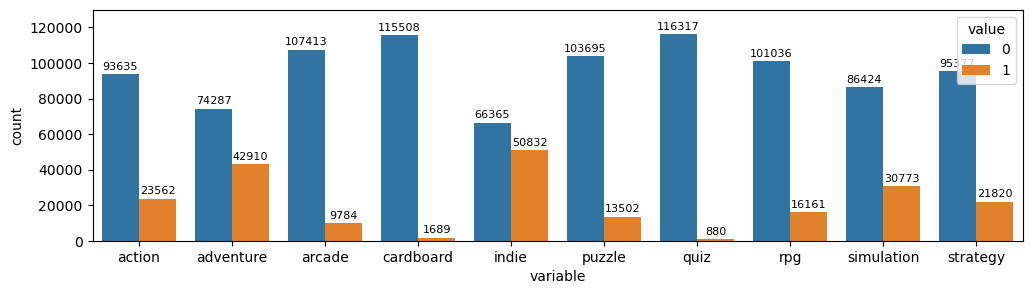

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

display(y_train[genre_cols].apply(lambda x: x.value_counts(normalize=True)))

plt.figure(figsize=(12,3))
ax = sns.countplot(x="variable", hue="value", data=pd.melt(y_train[genre_cols]))
ax.set_ylim(0,130000)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=2, fontsize=8)

plt.show()

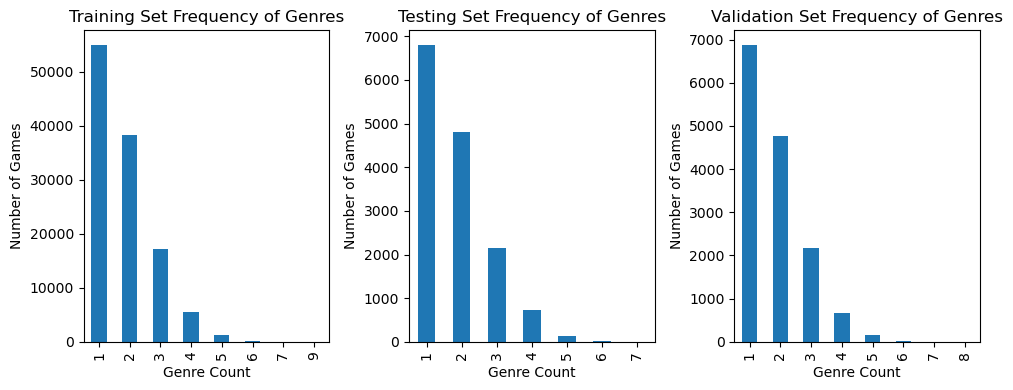

In [8]:
def freq_counter(df):
    freq_count = df['new_genrelist'].apply(len)
    return freq_count.value_counts()

training_freqcount = freq_counter(y_train)
testing_freqcount = freq_counter(y_test)
validation_freqcount = freq_counter(y_val)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
training_freqcount.plot(kind='bar', title='Training Set Frequency of Genres', xlabel='Genre Count', ylabel='Number of Games', ax=ax1)
testing_freqcount.plot(kind='bar', title='Testing Set Frequency of Genres', xlabel='Genre Count', ylabel='Number of Games', ax=ax2)
validation_freqcount.plot(kind='bar', title='Validation Set Frequency of Genres', xlabel='Genre Count', ylabel='Number of Games', ax=ax3)
plt.tight_layout()

### 📝 Compile genre tags binary results to list then merge

In [9]:
y_train['compiled_genrelist'] = y_train[genre_cols].values.tolist()
y_val['compiled_genrelist'] = y_val[genre_cols].values.tolist()

merged_trainset = pd.merge(X_train, y_train, on='id')[['clean_summary', 'compiled_genrelist']]
merged_valset = pd.merge(X_val, y_val, on='id')[['clean_summary', 'compiled_genrelist']]

In [10]:
display(merged_trainset)
display(merged_valset)

,clean_summary,compiled_genrelist
0,a grid based single local multiplayer strategy...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,top view racing game for wiiware by the makers...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,the idolmaster dearly stars is a japanese life...,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0]"
3,my daughter who was supposed to be dead is rig...,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]"
4,espn baseball tonight is a baseball game with ...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
...,...,...
117192,kero kero king is the predecessor to ribbit ki...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
117193,mighty chameleon brothers will remind you of o...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
117194,take control of one of the iconic british loco...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
117195,alchemist of war is a casual card game with cr...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"


,clean_summary,compiled_genrelist
0,a new legend begins here build and manage a to...,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 1]"
1,meet barnsley a lazy good for nothing badger w...,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,fire up a wild ride across the cosmos with a f...,"[1, 1, 0, 0, 0, 0, 0, 1, 0, 0]"
3,a special bonus disc that contained the both t...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,kings cross a unique mix of strategy rpg and t...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1]"
...,...,...
14645,own the child of light ultimate edition with t...,"[1, 1, 0, 0, 0, 0, 0, 1, 0, 1]"
14646,a side scroller adventure game with a slight t...,"[1, 1, 0, 0, 1, 1, 0, 0, 0, 0]"
14647,welcome to the chess game of tomorrow yesterye...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1]"
14648,a capcom developed adventure game released exc...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


# 📌 Handling Dataset Imbalance
---

# 📌 Preparation for Modelling
---

### 📝 Defining the Dataset Class

In [11]:
from torch.utils.data import Dataset, DataLoader

class MultiLabelDataset(Dataset):
    
    def __init__(self, df, tokenizer, max_len, new_data=False):
        self.tokenizer = tokenizer
        self.data = df
        self.text = df.clean_summary
        self.new_data = new_data
        self.max_len = max_len
        
        if not new_data:
            self.targets = self.data.compiled_genrelist
            
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = str(self.text[index])
        
        inputs = self.tokenizer.encode_plus(text,None,
                                           add_special_tokens=True,
                                           max_length=self.max_len,
                                           pad_to_max_length=True,
                                           return_token_type_ids=True)
        out = {
            "input_ids": torch.tensor(inputs['input_ids'], dtype=torch.long),
            "attention_mask": torch.tensor(inputs['attention_mask'], dtype=torch.long),
            "token_type_ids": torch.tensor(inputs['token_type_ids'], dtype=torch.long)
        }
        if not self.new_data:
            out["targets"] = torch.tensor(self.targets[index], dtype=torch.float)
            
        return out

### 📝 Defining the Configuration

In [12]:
MAX_LEN = 320
EPOCHS = 20
LEARNING_RATE = 1e-05
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda:0'

### 📝 Setting the Seeds

In [13]:
import os
import random
import torch

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

### 📝 Tokenizing and Creating Dataset then Loading it to the DataLoader

In [14]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True, model_max_length=MAX_LEN)
train_set = MultiLabelDataset(merged_trainset, tokenizer, MAX_LEN)
val_set = MultiLabelDataset(merged_valset, tokenizer, MAX_LEN)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=8)

# 📌 Model Development
---

### 📝 Defining DistilBERT Class Model

In [15]:
from transformers import DistilBertModel

class DistilBertClass(torch.nn.Module):
    def __init__(self):
        super(DistilBertClass, self).__init__()
        
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.classifier = torch.nn.Sequential(torch.nn.Linear(768, 768),
                                             torch.nn.ReLU(),
                                             torch.nn.Dropout(0.1),
                                             torch.nn.Linear(768, 10))
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        out = hidden_state[:,0]
        out = self.classifier(out)
        return out

### 📝 Initializing the Model and Moving it to GPU

In [16]:
model = DistilBertClass()
model.to(DEVICE)
print(f"Model on {DEVICE}")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model on cuda:0


### 📝 Defining Optimizer and Loss Function

In [17]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

def loss_fn(outputs, targets):
    return torch.nn.functional.binary_cross_entropy_with_logits(outputs,targets)

### 📝 Defining Training Loop

In [18]:
train_epoch_losses = []
val_epoch_losses = []

In [19]:
from tqdm.auto import tqdm

train_loss_values = [[] for i in range(EPOCHS)]

def train(epoch):
    model.train()
    
    latest_loss = 0
    
    for _, data in tqdm(enumerate(train_loader)):
        input_ids = data['input_ids'].to(DEVICE, dtype=torch.long)
        attention_mask = data['attention_mask'].to(DEVICE, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)
        targets = data['targets'].to(DEVICE, dtype=torch.float)
        
        outputs = model(input_ids, attention_mask, token_type_ids)
        
        loss = loss_fn(outputs, targets)
        if _ % 250 == 0:
            print(f"Epoch: {epoch}, Train Loss: {loss.item()}")
            train_loss_values[epoch].append(loss.item())
        latest_loss = loss.item()
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    train_epoch_losses.append(latest_loss)

### 📝 Defining Validation Loop

In [20]:
from sklearn import metrics

def validate():
    model.eval()

    fin_targets = []
    fin_outputs = []
    latest_loss = 0

    with torch.inference_mode():
        for _, data in tqdm(enumerate(val_loader, 0)):
            ids = data['input_ids'].to(DEVICE, dtype=torch.long)
            mask = data['attention_mask'].to(DEVICE, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)
            targets = data['targets'].to(DEVICE, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

            loss = loss_fn(outputs, targets)
            latest_loss = loss.item()
      
    fin_outputs = np.array(fin_outputs) >= 0.5
    accuracy = metrics.accuracy_score(fin_targets, fin_outputs)
    f1_score_micro = metrics.f1_score(fin_targets, fin_outputs, average='micro')
    f1_score_macro = metrics.f1_score(fin_targets, fin_outputs, average='macro')
    
    val_epoch_losses.append(latest_loss)

    return {
        "Accuracy Score": accuracy,
        "F1 score(micro)": f1_score_micro,
        "F1 score(macro)": f1_score_macro,
        "Validation Loss": latest_loss
    }

# 📌 Model Training/Finetuning
---

### 📝 Execute Training and Validation Process

In [21]:
for epoch in range(EPOCHS):
  train(epoch)
  print(validate())
  print('#' * 30)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 0, Train Loss: 0.6955325603485107
Epoch: 0, Train Loss: 0.38907814025878906
Epoch: 0, Train Loss: 0.29036155343055725
Epoch: 0, Train Loss: 0.3439602851867676
Epoch: 0, Train Loss: 0.322954922914505
Epoch: 0, Train Loss: 0.2998734414577484
Epoch: 0, Train Loss: 0.3423134684562683
Epoch: 0, Train Loss: 0.3252062499523163
Epoch: 0, Train Loss: 0.35585877299308777
Epoch: 0, Train Loss: 0.26707008481025696
Epoch: 0, Train Loss: 0.24708619713783264
Epoch: 0, Train Loss: 0.26672282814979553
Epoch: 0, Train Loss: 0.23223161697387695
Epoch: 0, Train Loss: 0.26263365149497986
Epoch: 0, Train Loss: 0.25482290983200073


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.3453924914675768, 'F1 score(micro)': 0.6579918594596875, 'F1 score(macro)': 0.5168835646081105, 'Validation Loss': 0.20304767787456512}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 1, Train Loss: 0.21788838505744934
Epoch: 1, Train Loss: 0.20389632880687714
Epoch: 1, Train Loss: 0.2817133069038391
Epoch: 1, Train Loss: 0.26244819164276123
Epoch: 1, Train Loss: 0.27860692143440247
Epoch: 1, Train Loss: 0.19546103477478027
Epoch: 1, Train Loss: 0.2976709306240082
Epoch: 1, Train Loss: 0.20221295952796936
Epoch: 1, Train Loss: 0.2458696812391281
Epoch: 1, Train Loss: 0.24562779068946838
Epoch: 1, Train Loss: 0.24252663552761078
Epoch: 1, Train Loss: 0.2570591866970062
Epoch: 1, Train Loss: 0.2522122859954834
Epoch: 1, Train Loss: 0.21000094711780548
Epoch: 1, Train Loss: 0.28046199679374695


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.3610238907849829, 'F1 score(micro)': 0.6769820339541782, 'F1 score(macro)': 0.5715151872698033, 'Validation Loss': 0.1815604865550995}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 2, Train Loss: 0.21914136409759521
Epoch: 2, Train Loss: 0.20997285842895508
Epoch: 2, Train Loss: 0.20568056404590607
Epoch: 2, Train Loss: 0.2407384216785431
Epoch: 2, Train Loss: 0.2630515396595001
Epoch: 2, Train Loss: 0.19120506942272186
Epoch: 2, Train Loss: 0.33156928420066833
Epoch: 2, Train Loss: 0.2195616215467453
Epoch: 2, Train Loss: 0.2746712863445282
Epoch: 2, Train Loss: 0.22905988991260529
Epoch: 2, Train Loss: 0.20442934334278107
Epoch: 2, Train Loss: 0.25786855816841125
Epoch: 2, Train Loss: 0.24698007106781006
Epoch: 2, Train Loss: 0.25084349513053894
Epoch: 2, Train Loss: 0.18965719640254974


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.375221843003413, 'F1 score(micro)': 0.6821145301274864, 'F1 score(macro)': 0.5653215526188367, 'Validation Loss': 0.18176141381263733}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 3, Train Loss: 0.23567461967468262
Epoch: 3, Train Loss: 0.20937637984752655
Epoch: 3, Train Loss: 0.19972382485866547
Epoch: 3, Train Loss: 0.2274438887834549
Epoch: 3, Train Loss: 0.1569318026304245
Epoch: 3, Train Loss: 0.20006899535655975
Epoch: 3, Train Loss: 0.21902723610401154
Epoch: 3, Train Loss: 0.25399625301361084
Epoch: 3, Train Loss: 0.25932660698890686
Epoch: 3, Train Loss: 0.20126557350158691
Epoch: 3, Train Loss: 0.21567773818969727
Epoch: 3, Train Loss: 0.22311483323574066
Epoch: 3, Train Loss: 0.2690725028514862
Epoch: 3, Train Loss: 0.21233105659484863
Epoch: 3, Train Loss: 0.2616322636604309


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.37897610921501707, 'F1 score(micro)': 0.69679091090293, 'F1 score(macro)': 0.592387148640088, 'Validation Loss': 0.17219077050685883}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 4, Train Loss: 0.22786493599414825
Epoch: 4, Train Loss: 0.20891594886779785
Epoch: 4, Train Loss: 0.1811387538909912
Epoch: 4, Train Loss: 0.2350407838821411
Epoch: 4, Train Loss: 0.2034001350402832
Epoch: 4, Train Loss: 0.23120546340942383
Epoch: 4, Train Loss: 0.2110411375761032
Epoch: 4, Train Loss: 0.14919884502887726
Epoch: 4, Train Loss: 0.21533799171447754
Epoch: 4, Train Loss: 0.20108714699745178
Epoch: 4, Train Loss: 0.1733141988515854
Epoch: 4, Train Loss: 0.21281543374061584
Epoch: 4, Train Loss: 0.21738183498382568
Epoch: 4, Train Loss: 0.1880018264055252
Epoch: 4, Train Loss: 0.19006431102752686


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.37597269624573376, 'F1 score(micro)': 0.6915738952064207, 'F1 score(macro)': 0.5882322959465079, 'Validation Loss': 0.18590450286865234}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 5, Train Loss: 0.15734513103961945
Epoch: 5, Train Loss: 0.14383266866207123
Epoch: 5, Train Loss: 0.16336147487163544
Epoch: 5, Train Loss: 0.1802709698677063
Epoch: 5, Train Loss: 0.18668434023857117
Epoch: 5, Train Loss: 0.22870397567749023
Epoch: 5, Train Loss: 0.20245282351970673
Epoch: 5, Train Loss: 0.15733622014522552
Epoch: 5, Train Loss: 0.1706753671169281
Epoch: 5, Train Loss: 0.17282643914222717
Epoch: 5, Train Loss: 0.18094795942306519
Epoch: 5, Train Loss: 0.15607903897762299
Epoch: 5, Train Loss: 0.2038695365190506
Epoch: 5, Train Loss: 0.22897987067699432
Epoch: 5, Train Loss: 0.19371412694454193


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.3751535836177474, 'F1 score(micro)': 0.6748712433036176, 'F1 score(macro)': 0.5988012692695384, 'Validation Loss': 0.20468547940254211}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 6, Train Loss: 0.14297962188720703
Epoch: 6, Train Loss: 0.16303707659244537
Epoch: 6, Train Loss: 0.20174197852611542
Epoch: 6, Train Loss: 0.14770789444446564
Epoch: 6, Train Loss: 0.1774129867553711
Epoch: 6, Train Loss: 0.11715403944253922
Epoch: 6, Train Loss: 0.1986183375120163
Epoch: 6, Train Loss: 0.16905935108661652
Epoch: 6, Train Loss: 0.10789697617292404
Epoch: 6, Train Loss: 0.12906908988952637
Epoch: 6, Train Loss: 0.19495880603790283
Epoch: 6, Train Loss: 0.16476351022720337
Epoch: 6, Train Loss: 0.1876762956380844
Epoch: 6, Train Loss: 0.17962487041950226
Epoch: 6, Train Loss: 0.16508756577968597


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.3670307167235495, 'F1 score(micro)': 0.6728736891214832, 'F1 score(macro)': 0.6005785233749215, 'Validation Loss': 0.20390096306800842}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 7, Train Loss: 0.1419798880815506
Epoch: 7, Train Loss: 0.19081686437129974
Epoch: 7, Train Loss: 0.2211368829011917
Epoch: 7, Train Loss: 0.18435446918010712
Epoch: 7, Train Loss: 0.15492622554302216
Epoch: 7, Train Loss: 0.1636998951435089
Epoch: 7, Train Loss: 0.16965623199939728
Epoch: 7, Train Loss: 0.16364985704421997
Epoch: 7, Train Loss: 0.1892983466386795
Epoch: 7, Train Loss: 0.169733464717865
Epoch: 7, Train Loss: 0.0952036902308464
Epoch: 7, Train Loss: 0.1045469269156456
Epoch: 7, Train Loss: 0.10248609632253647
Epoch: 7, Train Loss: 0.15946850180625916
Epoch: 7, Train Loss: 0.1817612648010254


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.36450511945392494, 'F1 score(micro)': 0.6744004014049173, 'F1 score(macro)': 0.5933209456777694, 'Validation Loss': 0.22242704033851624}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Epoch: 8, Train Loss: 0.17365023493766785
Epoch: 8, Train Loss: 0.12147947400808334
Epoch: 8, Train Loss: 0.21946020424365997
Epoch: 8, Train Loss: 0.1376858353614807
Epoch: 8, Train Loss: 0.21648640930652618
Epoch: 8, Train Loss: 0.12056245654821396
Epoch: 8, Train Loss: 0.1010194942355156
Epoch: 8, Train Loss: 0.17651915550231934
Epoch: 8, Train Loss: 0.07252147048711777
Epoch: 8, Train Loss: 0.10415581613779068
Epoch: 8, Train Loss: 0.15646004676818848
Epoch: 8, Train Loss: 0.13618414103984833
Epoch: 8, Train Loss: 0.14755690097808838
Epoch: 8, Train Loss: 0.16296760737895966
Epoch: 8, Train Loss: 0.11657903343439102


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.3604778156996587, 'F1 score(micro)': 0.6787110531927496, 'F1 score(macro)': 0.5977742876107467, 'Validation Loss': 0.22878150641918182}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 9, Train Loss: 0.12942272424697876
Epoch: 9, Train Loss: 0.11877494305372238
Epoch: 9, Train Loss: 0.09753819555044174
Epoch: 9, Train Loss: 0.11193814128637314
Epoch: 9, Train Loss: 0.1091570034623146
Epoch: 9, Train Loss: 0.09368740767240524
Epoch: 9, Train Loss: 0.1228310838341713
Epoch: 9, Train Loss: 0.11210744827985764
Epoch: 9, Train Loss: 0.104178287088871
Epoch: 9, Train Loss: 0.11805012077093124
Epoch: 9, Train Loss: 0.10583464056253433
Epoch: 9, Train Loss: 0.1424737274646759
Epoch: 9, Train Loss: 0.1405867338180542
Epoch: 9, Train Loss: 0.13082118332386017
Epoch: 9, Train Loss: 0.1460532397031784


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.355358361774744, 'F1 score(micro)': 0.6752661833553918, 'F1 score(macro)': 0.5927634450466882, 'Validation Loss': 0.23086045682430267}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 10, Train Loss: 0.09579885751008987
Epoch: 10, Train Loss: 0.07349732518196106
Epoch: 10, Train Loss: 0.1458590030670166
Epoch: 10, Train Loss: 0.10878552496433258
Epoch: 10, Train Loss: 0.1253511756658554
Epoch: 10, Train Loss: 0.09411753714084625
Epoch: 10, Train Loss: 0.1128884106874466
Epoch: 10, Train Loss: 0.07211096584796906
Epoch: 10, Train Loss: 0.1104600578546524
Epoch: 10, Train Loss: 0.10489892214536667
Epoch: 10, Train Loss: 0.10283613204956055
Epoch: 10, Train Loss: 0.09951533377170563
Epoch: 10, Train Loss: 0.11950173228979111
Epoch: 10, Train Loss: 0.08119814097881317
Epoch: 10, Train Loss: 0.09843495488166809


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.35017064846416385, 'F1 score(micro)': 0.6651604518644407, 'F1 score(macro)': 0.593257416642899, 'Validation Loss': 0.28643059730529785}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 11, Train Loss: 0.1176813468337059
Epoch: 11, Train Loss: 0.11590802669525146
Epoch: 11, Train Loss: 0.08374152332544327
Epoch: 11, Train Loss: 0.09882848709821701
Epoch: 11, Train Loss: 0.060601700097322464
Epoch: 11, Train Loss: 0.12869560718536377
Epoch: 11, Train Loss: 0.10170253366231918
Epoch: 11, Train Loss: 0.07304632663726807
Epoch: 11, Train Loss: 0.08258753269910812
Epoch: 11, Train Loss: 0.09152152389287949
Epoch: 11, Train Loss: 0.06542442739009857
Epoch: 11, Train Loss: 0.09957250207662582
Epoch: 11, Train Loss: 0.0733068585395813
Epoch: 11, Train Loss: 0.09700223058462143
Epoch: 11, Train Loss: 0.06364656239748001


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.3479863481228669, 'F1 score(micro)': 0.6684371004229369, 'F1 score(macro)': 0.5860728396331629, 'Validation Loss': 0.28152668476104736}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 12, Train Loss: 0.1148650199174881
Epoch: 12, Train Loss: 0.10877207666635513
Epoch: 12, Train Loss: 0.06911437958478928
Epoch: 12, Train Loss: 0.10773015022277832
Epoch: 12, Train Loss: 0.0725407674908638
Epoch: 12, Train Loss: 0.0447462797164917
Epoch: 12, Train Loss: 0.09850797802209854
Epoch: 12, Train Loss: 0.11840400844812393
Epoch: 12, Train Loss: 0.10467720031738281
Epoch: 12, Train Loss: 0.08245038241147995
Epoch: 12, Train Loss: 0.09311500191688538
Epoch: 12, Train Loss: 0.10794341564178467
Epoch: 12, Train Loss: 0.07608883082866669
Epoch: 12, Train Loss: 0.08393768221139908
Epoch: 12, Train Loss: 0.08450615406036377


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'Accuracy Score': 0.34225255972696245, 'F1 score(micro)': 0.6676709970261387, 'F1 score(macro)': 0.5878063886081428, 'Validation Loss': 0.32762643694877625}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 13, Train Loss: 0.07278336584568024
Epoch: 13, Train Loss: 0.09453817456960678
Epoch: 13, Train Loss: 0.06583454459905624
Epoch: 13, Train Loss: 0.07713910192251205
Epoch: 13, Train Loss: 0.06592392176389694
Epoch: 13, Train Loss: 0.0687277540564537
Epoch: 13, Train Loss: 0.05819019302725792
Epoch: 13, Train Loss: 0.06297151744365692
Epoch: 13, Train Loss: 0.05719001963734627
Epoch: 13, Train Loss: 0.08425968140363693
Epoch: 13, Train Loss: 0.08643008023500443
Epoch: 13, Train Loss: 0.07678717374801636
Epoch: 13, Train Loss: 0.0911421924829483
Epoch: 13, Train Loss: 0.05304589495062828
Epoch: 13, Train Loss: 0.0891152024269104


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.3272354948805461, 'F1 score(micro)': 0.6654086388768328, 'F1 score(macro)': 0.5914831973220334, 'Validation Loss': 0.30890050530433655}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 14, Train Loss: 0.06387155503034592
Epoch: 14, Train Loss: 0.1036592647433281
Epoch: 14, Train Loss: 0.08482653647661209
Epoch: 14, Train Loss: 0.11797714233398438
Epoch: 14, Train Loss: 0.046728070825338364
Epoch: 14, Train Loss: 0.09950369596481323
Epoch: 14, Train Loss: 0.053660858422517776
Epoch: 14, Train Loss: 0.06858571618795395
Epoch: 14, Train Loss: 0.053582023829221725
Epoch: 14, Train Loss: 0.06737891584634781
Epoch: 14, Train Loss: 0.06683946400880814
Epoch: 14, Train Loss: 0.025319913402199745
Epoch: 14, Train Loss: 0.0699639767408371
Epoch: 14, Train Loss: 0.0770975723862648
Epoch: 14, Train Loss: 0.0789555236697197


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'Accuracy Score': 0.33706484641638224, 'F1 score(micro)': 0.6637076836224182, 'F1 score(macro)': 0.5925887088632913, 'Validation Loss': 0.35170653462409973}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 15, Train Loss: 0.03902840614318848
Epoch: 15, Train Loss: 0.06496987491846085
Epoch: 15, Train Loss: 0.025140592828392982
Epoch: 15, Train Loss: 0.062341153621673584
Epoch: 15, Train Loss: 0.05429287627339363
Epoch: 15, Train Loss: 0.037461474537849426
Epoch: 15, Train Loss: 0.07526989281177521
Epoch: 15, Train Loss: 0.05109523609280586
Epoch: 15, Train Loss: 0.04459909349679947
Epoch: 15, Train Loss: 0.07337754964828491
Epoch: 15, Train Loss: 0.07098168134689331
Epoch: 15, Train Loss: 0.07367207854986191
Epoch: 15, Train Loss: 0.07880938053131104
Epoch: 15, Train Loss: 0.06410068273544312
Epoch: 15, Train Loss: 0.05648067221045494


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.33351535836177476, 'F1 score(micro)': 0.6672650192873238, 'F1 score(macro)': 0.592709562942372, 'Validation Loss': 0.3245147466659546}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 16, Train Loss: 0.03351913020014763
Epoch: 16, Train Loss: 0.03658778592944145
Epoch: 16, Train Loss: 0.05051032453775406
Epoch: 16, Train Loss: 0.07480242848396301
Epoch: 16, Train Loss: 0.042475320398807526
Epoch: 16, Train Loss: 0.08242882788181305
Epoch: 16, Train Loss: 0.04918050393462181
Epoch: 16, Train Loss: 0.1170571818947792
Epoch: 16, Train Loss: 0.05130366235971451
Epoch: 16, Train Loss: 0.04888276383280754
Epoch: 16, Train Loss: 0.06815468519926071
Epoch: 16, Train Loss: 0.027138177305459976
Epoch: 16, Train Loss: 0.05154497176408768
Epoch: 16, Train Loss: 0.056031741201877594
Epoch: 16, Train Loss: 0.04353819414973259


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.33986348122866894, 'F1 score(micro)': 0.66085149756939, 'F1 score(macro)': 0.5912533667936966, 'Validation Loss': 0.34654009342193604}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch: 17, Train Loss: 0.01479390263557434
Epoch: 17, Train Loss: 0.021113289520144463
Epoch: 17, Train Loss: 0.02691327966749668
Epoch: 17, Train Loss: 0.11279413849115372
Epoch: 17, Train Loss: 0.0308903306722641
Epoch: 17, Train Loss: 0.03504977747797966
Epoch: 17, Train Loss: 0.10240284353494644
Epoch: 17, Train Loss: 0.044979386031627655
Epoch: 17, Train Loss: 0.07451181858778
Epoch: 17, Train Loss: 0.03919145464897156
Epoch: 17, Train Loss: 0.04993138089776039
Epoch: 17, Train Loss: 0.06260775774717331
Epoch: 17, Train Loss: 0.02761944942176342
Epoch: 17, Train Loss: 0.06513117253780365
Epoch: 17, Train Loss: 0.07936626672744751


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.3392491467576792, 'F1 score(micro)': 0.6672752699867921, 'F1 score(macro)': 0.5856266940787593, 'Validation Loss': 0.4019755721092224}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 18, Train Loss: 0.03983859345316887
Epoch: 18, Train Loss: 0.05449603870511055
Epoch: 18, Train Loss: 0.028477272018790245
Epoch: 18, Train Loss: 0.0617448091506958
Epoch: 18, Train Loss: 0.08663337677717209
Epoch: 18, Train Loss: 0.06957685202360153
Epoch: 18, Train Loss: 0.05402427539229393
Epoch: 18, Train Loss: 0.021052563562989235
Epoch: 18, Train Loss: 0.03290298208594322
Epoch: 18, Train Loss: 0.027387255802750587
Epoch: 18, Train Loss: 0.030364511534571648
Epoch: 18, Train Loss: 0.04095880687236786
Epoch: 18, Train Loss: 0.054572343826293945
Epoch: 18, Train Loss: 0.030167466029524803
Epoch: 18, Train Loss: 0.024037817493081093


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.3320819112627986, 'F1 score(micro)': 0.6637507673419276, 'F1 score(macro)': 0.5886676066255692, 'Validation Loss': 0.4052569568157196}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 19, Train Loss: 0.058016031980514526
Epoch: 19, Train Loss: 0.023836851119995117
Epoch: 19, Train Loss: 0.01809288188815117
Epoch: 19, Train Loss: 0.0430038645863533
Epoch: 19, Train Loss: 0.0345902293920517
Epoch: 19, Train Loss: 0.019564582034945488
Epoch: 19, Train Loss: 0.04453837871551514
Epoch: 19, Train Loss: 0.050090499222278595
Epoch: 19, Train Loss: 0.025319043546915054
Epoch: 19, Train Loss: 0.02474367432296276
Epoch: 19, Train Loss: 0.06524451076984406
Epoch: 19, Train Loss: 0.03867371007800102
Epoch: 19, Train Loss: 0.04144484922289848
Epoch: 19, Train Loss: 0.05114264413714409
Epoch: 19, Train Loss: 0.03032379224896431


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.33474402730375424, 'F1 score(micro)': 0.6637240097572308, 'F1 score(macro)': 0.5866465162309671, 'Validation Loss': 0.4470564126968384}
##############################


# 📌 Model Testing/Predictions
---

### 📝 Creating Test Dataset then Loading it to the DataLoader

In [22]:
X_test

,id,clean_summary
0,169256,visit a variety of water attractions with jasm...
1,33905,how to play a game that doesn want to be playe...
2,81241,these are the last days of the first planet ex...
3,6601,it time to get the party started right with so...
4,69434,is a non interactive short simple story follow...
...,...,...
14645,158107,disc golf valley is home to some of the most b...
14646,52238,sequel to the hit game happy wars a game that ...
14647,164170,driiift your way through tons of obstacles and...
14648,137139,select characters have been chosen to debut as...


In [23]:
test_set = MultiLabelDataset(X_test, tokenizer, MAX_LEN, new_data=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=8)

### 📝 Use Trained Model to Predict on Test Data

In [24]:
all_test_pred = []

def prediction():
  model.eval()

  with torch.inference_mode():
    for _, data in tqdm(enumerate(test_loader, 0)):
      ids = data['input_ids'].to(DEVICE, dtype=torch.long)
      mask = data['attention_mask'].to(DEVICE, dtype=torch.long)
      token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)
      outputs = model(ids, mask, token_type_ids)
      probas = torch.sigmoid(outputs)

      all_test_pred.append(probas)
  return probas
probabilities = prediction()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

In [25]:
all_test_pred = torch.cat(all_test_pred)

In [26]:
submit_df = X_test.copy()
submit_df.drop('clean_summary', inplace=True, axis=1)

In [27]:
for i,name in enumerate(genre_cols):

    submit_df[name] = all_test_pred[:, i].cpu()
    submit_df.head()

In [28]:
submit_df.to_csv('/kaggle/working/submission.csv', index=False)

In [29]:
submit_df

,id,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,4.580839e-09,7.345092e-01,3.076981e-07,1.586834e-07,0.995062,3.273013e-07,1.771643e-07,9.458004e-06,0.569314,1.166698e-03
1,33905,1.241704e-05,1.741710e-01,1.719513e-07,1.932689e-08,0.935820,1.193268e-02,9.034525e-08,1.390992e-03,0.000027,5.023035e-03
2,81241,1.841941e-02,9.976832e-01,1.181266e-05,1.115661e-06,0.901257,5.798905e-08,4.113549e-06,7.762358e-02,0.000115,1.935571e-04
3,6601,4.962280e-06,5.196835e-04,9.995139e-01,1.320205e-02,0.000017,3.743192e-03,4.928780e-06,1.765777e-05,0.007925,2.545107e-06
4,69434,1.424624e-06,9.999517e-01,5.367010e-07,2.018372e-08,0.841442,2.718466e-06,2.920301e-07,1.569415e-03,0.025029,2.954353e-07
...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,1.699381e-06,9.095477e-07,4.071980e-02,5.354063e-06,0.005366,6.809326e-04,1.363066e-06,9.862836e-07,0.999997,1.801650e-06
14646,52238,7.435890e-02,6.466790e-01,6.645323e-03,4.639912e-04,0.020325,3.692500e-03,7.824018e-04,9.523156e-01,0.001424,5.165672e-01
14647,164170,9.659734e-02,7.405282e-03,8.163453e-01,2.476396e-04,0.247267,2.457376e-01,1.902520e-04,2.343574e-04,0.006244,4.177302e-03
14648,137139,1.375914e-04,1.485402e-06,6.832988e-05,4.185347e-06,0.000006,9.999070e-01,7.090344e-06,9.708316e-07,0.000004,7.555599e-02


# 📌 Model Evaluation
---

### 📝 Show Proababilities and Actual Values Dataframe

In [30]:
predictions_df = submit_df
predictions_df

,id,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,4.580839e-09,7.345092e-01,3.076981e-07,1.586834e-07,0.995062,3.273013e-07,1.771643e-07,9.458004e-06,0.569314,1.166698e-03
1,33905,1.241704e-05,1.741710e-01,1.719513e-07,1.932689e-08,0.935820,1.193268e-02,9.034525e-08,1.390992e-03,0.000027,5.023035e-03
2,81241,1.841941e-02,9.976832e-01,1.181266e-05,1.115661e-06,0.901257,5.798905e-08,4.113549e-06,7.762358e-02,0.000115,1.935571e-04
3,6601,4.962280e-06,5.196835e-04,9.995139e-01,1.320205e-02,0.000017,3.743192e-03,4.928780e-06,1.765777e-05,0.007925,2.545107e-06
4,69434,1.424624e-06,9.999517e-01,5.367010e-07,2.018372e-08,0.841442,2.718466e-06,2.920301e-07,1.569415e-03,0.025029,2.954353e-07
...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,1.699381e-06,9.095477e-07,4.071980e-02,5.354063e-06,0.005366,6.809326e-04,1.363066e-06,9.862836e-07,0.999997,1.801650e-06
14646,52238,7.435890e-02,6.466790e-01,6.645323e-03,4.639912e-04,0.020325,3.692500e-03,7.824018e-04,9.523156e-01,0.001424,5.165672e-01
14647,164170,9.659734e-02,7.405282e-03,8.163453e-01,2.476396e-04,0.247267,2.457376e-01,1.902520e-04,2.343574e-04,0.006244,4.177302e-03
14648,137139,1.375914e-04,1.485402e-06,6.832988e-05,4.185347e-06,0.000006,9.999070e-01,7.090344e-06,9.708316e-07,0.000004,7.555599e-02


In [31]:
actual_df = y_test
actual_df

,id,new_genrelist,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,"[adventure, indie]",0,1,0,0,1,0,0,0,0,0
1,33905,"[indie, puzzle]",0,0,0,0,1,1,0,0,0,0
2,81241,[adventure],0,1,0,0,0,0,0,0,0,0
3,6601,"[arcade, simulation]",0,0,1,0,0,0,0,0,1,0
4,69434,"[adventure, indie]",0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,[simulation],0,0,0,0,0,0,0,0,1,0
14646,52238,[rpg],0,0,0,0,0,0,0,1,0,0
14647,164170,"[indie, simulation]",0,0,0,0,1,0,0,0,1,0
14648,137139,"[puzzle, strategy]",0,0,0,0,0,1,0,0,0,1


### 📝 Calculate for AUC ROC Score

In [32]:
%pip install -q torchmetrics watermark

Note: you may need to restart the kernel to use updated packages.


In [33]:
%load_ext watermark

In [34]:
%watermark --iversions

numpy     : 1.21.6
re        : 2.2.1
matplotlib: 3.5.3
sklearn   : 1.0.2
torch     : 1.13.0
dill      : 0.3.6
pandas    : 1.3.5
seaborn   : 0.12.2



### Check Train and Validation Losses

In [1]:
train_epoch_losses

[0.27182433009147644,
 0.25895968079566956,
 0.2540246248245239,
 0.16199208796024323,
 0.19474740326404572,
 0.15124858915805817,
 0.13843975961208344,
 0.16843940317630768,
 0.07470889389514923,
 0.09209572523832321,
 0.11909552663564682,
 0.13705605268478394,
 0.0434127151966095,
 0.1180434599518776,
 0.06206051632761955,
 0.07421642541885376,
 0.043622083961963654,
 0.02824312448501587,
 0.012887447141110897,
 0.07756275683641434]

In [2]:
val_epoch_losses

[0.20304767787456512,
 0.1815604865550995,
 0.18176141381263733,
 0.17219077050685883,
 0.18590450286865234,
 0.20468547940254211,
 0.20390096306800842,
 0.22242704033851624,
 0.22878150641918182,
 0.23086045682430267,
 0.28643059730529785,
 0.28152668476104736,
 0.32762643694877625,
 0.30890050530433655,
 0.35170653462409973,
 0.3245147466659546,
 0.34654009342193604,
 0.4019755721092224,
 0.4052569568157196,
 0.4470564126968384]

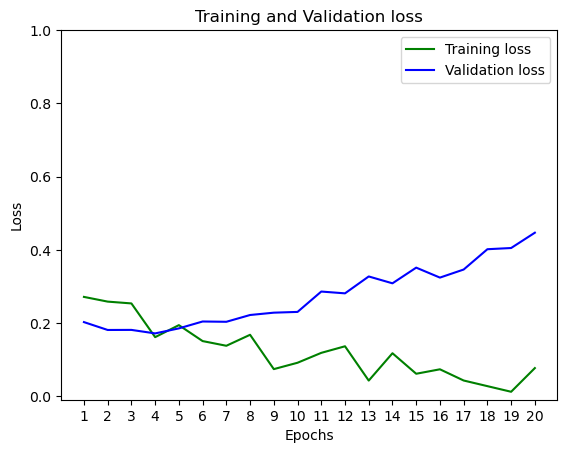

In [34]:
epochs = [str(x) for x in range(1,EPOCHS+1)]

fig, ax = plt.subplots()

ax.plot(epochs, train_epoch_losses, 'g', label='Training loss')
ax.plot(epochs, val_epoch_losses, 'b', label='Validation loss')

ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_ylim(top=1)
ax.legend()

plt.show()

### 📝 Calculate for ROC AUC Score

In [35]:
# Score for each cat
import torchmetrics

for cat in genre_cols:
    
    print(f"Category: {cat}")
    print(f"Sklearn score: {metrics.roc_auc_score(actual_df[cat], predictions_df[cat])}")
    #print(f"Sklearn score: {metrics.roc_auc_score(actual_df[cat], predictions_df[cat], average='weighted')}")
    print(f"torchmetrics score: {torchmetrics.functional.classification.binary_auroc(torch.tensor(predictions_df[cat].values),torch.tensor(actual_df[cat].values), thresholds=None)}")
    print("#" * 30)
    print()

Category: action
Sklearn score: 0.8816600943163767
torchmetrics score: 0.8816600441932678
##############################

Category: adventure
Sklearn score: 0.8434254994703345
torchmetrics score: 0.8434255123138428
##############################

Category: arcade
Sklearn score: 0.7940161918006732
torchmetrics score: 0.7940161824226379
##############################

Category: cardboard
Sklearn score: 0.8984793350806669
torchmetrics score: 0.8984793424606323
##############################

Category: indie
Sklearn score: 0.8547603786025885
torchmetrics score: 0.8547603487968445
##############################

Category: puzzle
Sklearn score: 0.8534894345940177
torchmetrics score: 0.8534893989562988
##############################

Category: quiz
Sklearn score: 0.8951616744914757
torchmetrics score: 0.8951616287231445
##############################

Category: rpg
Sklearn score: 0.8619692490118578
torchmetrics score: 0.8619692325592041
##############################

Category: simulation
Skl

In [36]:
# mean column-wise score on all categories
print(f"Sklearn score(micro): {metrics.roc_auc_score(actual_df[genre_cols].values, predictions_df[genre_cols].values,average='micro')}")
print(F"torchmetrics score(micro): {torchmetrics.functional.classification.multilabel_auroc(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None,average='micro')}")

print()
print(f"Sklearn score(macro): {metrics.roc_auc_score(actual_df[genre_cols].values, predictions_df[genre_cols].values,average='macro')}")
print(F"torchmetrics score(macro): {torchmetrics.functional.classification.multilabel_auroc(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None,average='macro')}")

print()
print(f"Sklearn score(weighted): {metrics.roc_auc_score(actual_df[genre_cols].values, predictions_df[genre_cols].values, average='weighted')}")
print(F"torchmetrics score(weighted): {torchmetrics.functional.classification.multilabel_auroc(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None,average='weighted' )}")

Sklearn score(micro): 0.8954208461964367
torchmetrics score(micro): 0.8954209089279175

Sklearn score(macro): 0.8602440589712355
torchmetrics score(macro): 0.86024409532547

Sklearn score(weighted): 0.8553574240428242
torchmetrics score(weighted): 0.8553574085235596


### 📝 Calculate for Average Precision Score

In [37]:
# score for each genre categories

for cat in genre_cols:
    
    print(f"Category: {cat}")
    print(f"Sklearn score: {metrics.average_precision_score(actual_df[cat], predictions_df[cat])}")
    #print(f"Sklearn score: {metrics.average_precision_score(actual_df[cat], predictions_df[cat], average='weighted')}")
    print(f"torchmetrics score: {torchmetrics.functional.classification.binary_average_precision(torch.tensor(predictions_df[cat].values),torch.tensor(actual_df[cat].values), thresholds=None)}")
    print("#" * 30)
    print()

Category: action
Sklearn score: 0.7163831165931579
torchmetrics score: 0.7163830995559692
##############################

Category: adventure
Sklearn score: 0.7546822901982465
torchmetrics score: 0.7546822428703308
##############################

Category: arcade
Sklearn score: 0.3865733194459144
torchmetrics score: 0.38657331466674805
##############################

Category: cardboard
Sklearn score: 0.3249639034988954
torchmetrics score: 0.32496389746665955
##############################

Category: indie
Sklearn score: 0.7851502473944738
torchmetrics score: 0.7851502895355225
##############################

Category: puzzle
Sklearn score: 0.5622590377597156
torchmetrics score: 0.5622590184211731
##############################

Category: quiz
Sklearn score: 0.400055069662766
torchmetrics score: 0.40005508065223694
##############################

Category: rpg
Sklearn score: 0.6343344094100992
torchmetrics score: 0.6343344449996948
##############################

Category: simulation
S

In [38]:
# mean column-wise score on all categories
print()
print(f"Sklearn score(micro): {metrics.average_precision_score(actual_df[genre_cols].values, predictions_df[genre_cols].values, average='micro')}")
print(F"torchmetrics score(micro): {torchmetrics.functional.classification.multilabel_average_precision(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None, average='micro')}")

print()
print(f"Sklearn score(macro): {metrics.average_precision_score(actual_df[genre_cols].values, predictions_df[genre_cols].values, average='macro')}")
print(F"torchmetrics score(macro): {torchmetrics.functional.classification.multilabel_average_precision(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None, average='macro')}")

print()
print(f"Sklearn score(weighted): {metrics.average_precision_score(actual_df[genre_cols].values, predictions_df[genre_cols].values, average='weighted')}")
print(F"torchmetrics score(weighted): {torchmetrics.functional.classification.multilabel_average_precision(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None,average='weighted' )}")


Sklearn score(micro): 0.7195664526244117
torchmetrics score(micro): 0.7195664048194885

Sklearn score(macro): 0.6050351652105326
torchmetrics score(macro): 0.6050351858139038

Sklearn score(weighted): 0.7129694811499045
torchmetrics score(weighted): 0.7129695415496826


## ⚠ Beyond this point, I am thresholding the predictions to 0.5. Be warned.

In [39]:
thresholded_preds = predictions_df.copy()

for cat in genre_cols:
    thresholded_preds[cat] = (thresholded_preds[cat] >= 0.5).astype(int)

display(predictions_df)
display(thresholded_preds)

,id,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,4.580839e-09,7.345092e-01,3.076981e-07,1.586834e-07,0.995062,3.273013e-07,1.771643e-07,9.458004e-06,0.569314,1.166698e-03
1,33905,1.241704e-05,1.741710e-01,1.719513e-07,1.932689e-08,0.935820,1.193268e-02,9.034525e-08,1.390992e-03,0.000027,5.023035e-03
2,81241,1.841941e-02,9.976832e-01,1.181266e-05,1.115661e-06,0.901257,5.798905e-08,4.113549e-06,7.762358e-02,0.000115,1.935571e-04
3,6601,4.962280e-06,5.196835e-04,9.995139e-01,1.320205e-02,0.000017,3.743192e-03,4.928780e-06,1.765777e-05,0.007925,2.545107e-06
4,69434,1.424624e-06,9.999517e-01,5.367010e-07,2.018372e-08,0.841442,2.718466e-06,2.920301e-07,1.569415e-03,0.025029,2.954353e-07
...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,1.699381e-06,9.095477e-07,4.071980e-02,5.354063e-06,0.005366,6.809326e-04,1.363066e-06,9.862836e-07,0.999997,1.801650e-06
14646,52238,7.435890e-02,6.466790e-01,6.645323e-03,4.639912e-04,0.020325,3.692500e-03,7.824018e-04,9.523156e-01,0.001424,5.165672e-01
14647,164170,9.659734e-02,7.405282e-03,8.163453e-01,2.476396e-04,0.247267,2.457376e-01,1.902520e-04,2.343574e-04,0.006244,4.177302e-03
14648,137139,1.375914e-04,1.485402e-06,6.832988e-05,4.185347e-06,0.000006,9.999070e-01,7.090344e-06,9.708316e-07,0.000004,7.555599e-02


,id,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,0,1,0,0,1,0,0,0,1,0
1,33905,0,0,0,0,1,0,0,0,0,0
2,81241,0,1,0,0,1,0,0,0,0,0
3,6601,0,0,1,0,0,0,0,0,0,0
4,69434,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,0,0,0,0,0,0,0,0,1,0
14646,52238,0,1,0,0,0,0,0,1,0,1
14647,164170,0,0,1,0,0,0,0,0,0,0
14648,137139,0,0,0,0,0,1,0,0,0,0


### 📝 Getting Confusion Matrix

In [40]:
mlb_cm = metrics.multilabel_confusion_matrix(y_true=actual_df[genre_cols].values, y_pred=thresholded_preds[genre_cols].values)

,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,0.797133,0.629283,0.912628,0.984573,0.568396,0.886212,0.992014,0.863481,0.736655,0.812082
1,0.202867,0.370717,0.087372,0.015427,0.431604,0.113788,0.007986,0.136519,0.263345,0.187918


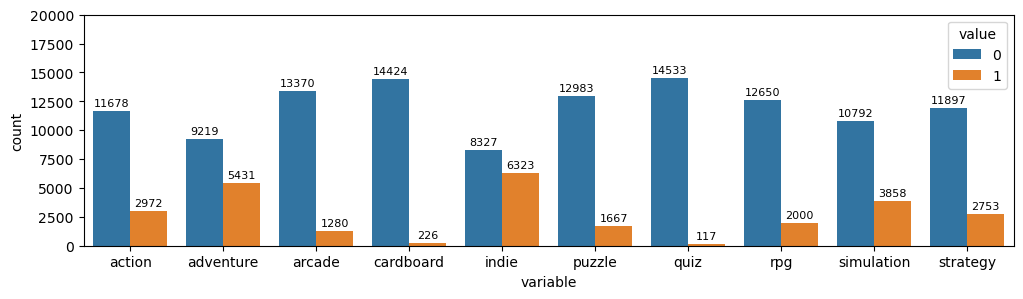

In [41]:
# displaying test set distribution as a proof of validation to our confusion matrices

display(y_test[genre_cols].apply(lambda x: x.value_counts(normalize=True)))

plt.figure(figsize=(12,3))
ax = sns.countplot(x="variable", hue="value", data=pd.melt(y_test[genre_cols]))
ax.set_ylim(0,20000)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=2, fontsize=8)

plt.show()

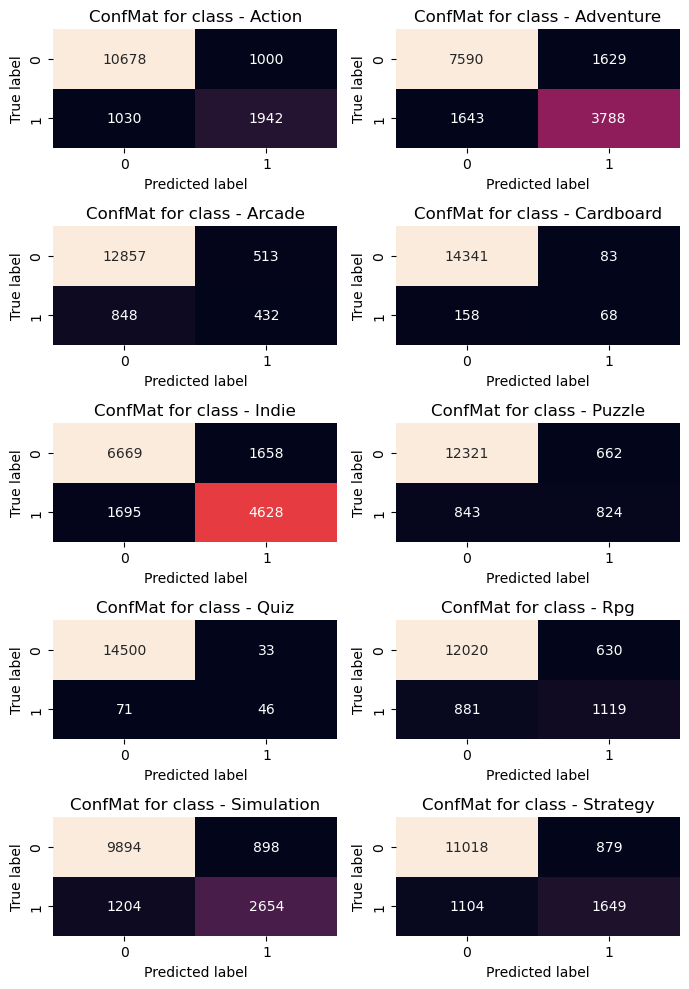

In [42]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
#     heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
#     heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right')
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("ConfMat for class - " + class_label.capitalize())
    
fig, ax = plt.subplots(5, 2, figsize=(7, 10))
    
for axes, cfs_matrix, label in zip(ax.flatten(), mlb_cm, genre_cols):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])

fig.tight_layout()
plt.show()

### 📝 Classification Report

In [43]:
print(metrics.classification_report(actual_df[genre_cols].values, thresholded_preds[genre_cols].values, target_names=genre_cols))

              precision    recall  f1-score   support

      action       0.66      0.65      0.66      2972
   adventure       0.70      0.70      0.70      5431
      arcade       0.46      0.34      0.39      1280
   cardboard       0.45      0.30      0.36       226
       indie       0.74      0.73      0.73      6323
      puzzle       0.55      0.49      0.52      1667
        quiz       0.58      0.39      0.47       117
         rpg       0.64      0.56      0.60      2000
  simulation       0.75      0.69      0.72      3858
    strategy       0.65      0.60      0.62      2753

   micro avg       0.68      0.64      0.66     26627
   macro avg       0.62      0.55      0.58     26627
weighted avg       0.68      0.64      0.66     26627
 samples avg       0.71      0.70      0.66     26627



### 📝 Getting F1 Score

In [44]:
for cat in genre_cols:
    
    print(f"Category: {cat}")
    print(f"Sklearn score: {metrics.f1_score(actual_df[cat], thresholded_preds[cat])}")
    print(f"torchmetrics score: {torchmetrics.functional.classification.binary_f1_score(torch.tensor(predictions_df[cat].values),torch.tensor(actual_df[cat].values))}")
#     print(f"torchmetrics score(orig): {torchmetrics.functional.classification.binary_f1_score(torch.tensor(thresholded_preds[cat].values),torch.tensor(actual_df[cat].values), threshold=0.5)}")
    print("#" * 30)
    print()

Category: action
Sklearn score: 0.6567467027392628
torchmetrics score: 0.6567466855049133
##############################

Category: adventure
Sklearn score: 0.698377581120944
torchmetrics score: 0.6983776092529297
##############################

Category: arcade
Sklearn score: 0.38831460674157303
torchmetrics score: 0.3883146047592163
##############################

Category: cardboard
Sklearn score: 0.36074270557029176
torchmetrics score: 0.3607427179813385
##############################

Category: indie
Sklearn score: 0.7340788325799031
torchmetrics score: 0.7340788245201111
##############################

Category: puzzle
Sklearn score: 0.5226768157310497
torchmetrics score: 0.5226768255233765
##############################

Category: quiz
Sklearn score: 0.46938775510204084
torchmetrics score: 0.4693877696990967
##############################

Category: rpg
Sklearn score: 0.5969591891170979
torchmetrics score: 0.5969591736793518
##############################

Category: simulation
S

In [45]:
print(f"Sklearn score(micro): {metrics.f1_score(actual_df[genre_cols].values, thresholded_preds[genre_cols].values, average='micro')}")
print(f"torchmetrics score(micro): {torchmetrics.functional.classification.multilabel_f1_score(torch.tensor(thresholded_preds[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,average='macro')}")

print()
print(f"Sklearn score(macro): {metrics.f1_score(actual_df[genre_cols].values, thresholded_preds[genre_cols].values, average='macro')}")
print(f"torchmetrics score(macro): {torchmetrics.functional.classification.multilabel_f1_score(torch.tensor(thresholded_preds[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,average='macro')}")

print()
print(f"Sklearn score(weighted): {metrics.f1_score(actual_df[genre_cols].values, thresholded_preds[genre_cols].values, average='weighted')}")
print(f"torchmetrics score(weighted): {torchmetrics.functional.classification.multilabel_f1_score(torch.tensor(thresholded_preds[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,average='weighted')}")

Sklearn score(micro): 0.6626482747961826
torchmetrics score(micro): 0.576811671257019

Sklearn score(macro): 0.576811640850268
torchmetrics score(macro): 0.576811671257019

Sklearn score(weighted): 0.6597770987443011
torchmetrics score(weighted): 0.6597771048545837
